In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from datetime import datetime
from elasticsearch import Elasticsearch
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'])

In [83]:
my_index = "network_weather_2-2016.7.29"

my_query = \
{
  "size": 10000,
  "sort": [
    {
      "timestamp": {
        "order": "desc",
        "unmapped_type": "boolean"
      }
    }
  ],
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False,
          "query": "*"
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "match": {
                  "src": {
                    "query": "149.165.225.223",
                    "type": "phrase"
                  }
                }
              }
            },
            {
              "query": {
                "match": {
                  "dest": {
                    "query": "192.170.227.160",
                    "type": "phrase"
                  }
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "1h",
        "time_zone": "America/Chicago",
        "min_doc_count": 0,
        "extended_bounds": {
          "min": 1469236545000,
          "max": 1469942416000
        }
      }
    }
  },
  "fields": [
    "*",
    "_source"
  ],
  "script_fields": {
    "throughput [Gbps]": {
      "script": "doc['throughput'].value/1073741824.0",
      "lang": "expression"
    }
  },
  "fielddata_fields": [
    "timestamp"
  ]
}

In [84]:
response = es.search(index=my_index, body=my_query, request_timeout=600)

In [85]:
#for key in response.keys():
#    print(key)

In [86]:
#response

In [87]:
import pandas as pd

In [88]:
latency_rawdata = pd.DataFrame(columns=['timestamp','delay_mean','delay_median','delay_sd'])
packet_loss_rate_rawdata = pd.DataFrame(columns=['timestamp','packet_loss'])
throughput_rawdata = pd.DataFrame(columns=['timestamp','throughput'])

In [89]:
row_l = 0
row_p = 0
row_t = 0

for hit in response['hits']['hits']:
    item = hit['_source']
    dt = datetime.fromtimestamp(int(hit['fields']['timestamp'][0]/1000))
    if hit['_type'] == 'latency':
        latency_rawdata.loc[row_l] = [dt, item['delay_mean'], item['delay_median'], item['delay_sd']]
        row_l += 1
    elif hit['_type'] == 'packet_loss_rate':
        packet_loss_rate_rawdata.loc[row_p] = [dt, item['packet_loss']]
        row_p += 1
    elif hit['_type'] == 'throughput':
        throughput_rawdata.loc[row_t] = [dt, item['throughput']]
        row_t += 1

In [90]:
print(row_l)
print(row_p)
print(row_t)

287
287
0


In [91]:
latency_rawdata = latency_rawdata.drop_duplicates()
latency_rawdata = latency_rawdata.set_index('timestamp')

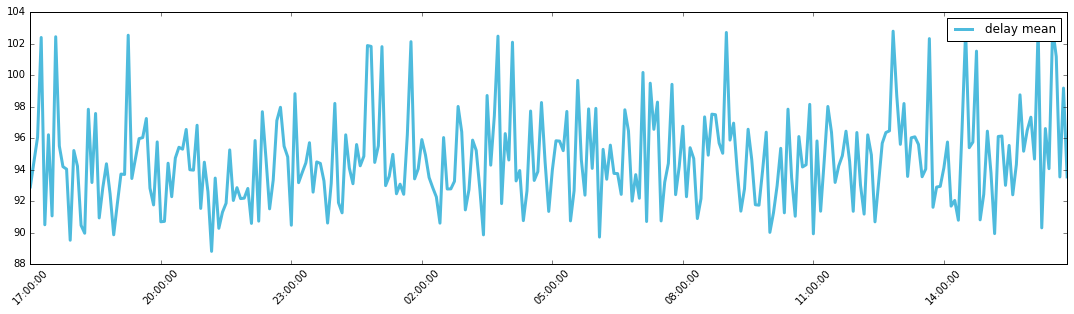

In [92]:
plt.figure()
plt.plot(latency_rawdata.delay_mean,label="delay mean",linewidth=3, color='#4ebbdd')
#plt.plot(latency_rawdata.delay_median,label="delay median",linewidth=1, color='#265e70')
plt.legend()
_, labels = plt.xticks()
plt.setp(labels, rotation=45)
fig = plt.gcf()
fig.set_size_inches(18, 5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.savefig("latency_rawdata_meanmedian.png",dpi=150)
plt.show()

In [47]:
packet_loss_rate_rawdata = packet_loss_rate_rawdata.drop_duplicates()
packet_loss_rate_rawdata = packet_loss_rate_rawdata.set_index('timestamp')

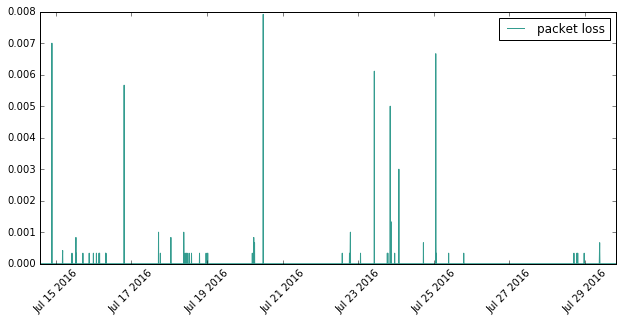

In [48]:
plt.figure()
plt.plot(packet_loss_rate_rawdata.packet_loss,label="packet loss",linewidth=1, color='#349c8f')
plt.legend()
_, labels = plt.xticks()
plt.setp(labels, rotation=45)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.savefig("packet_loss_rate_rawdata.png",dpi=150)
plt.show()

In [49]:
throughput_rawdata = throughput_rawdata.drop_duplicates()
throughput_rawdata = throughput_rawdata.set_index('timestamp')

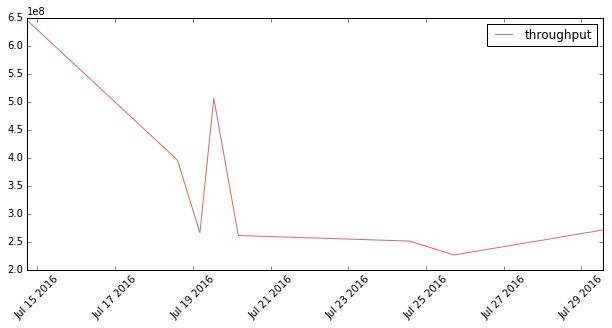

In [50]:
plt.figure()
plt.plot(throughput_rawdata.throughput,label="throughput",linewidth=1, color='#dd6a62')
plt.legend()
_, labels = plt.xticks()
plt.setp(labels, rotation=45)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.savefig("throughput_rawdata.png",dpi=150)
plt.show()